## Load packages

In [1]:
import os
from pathlib import Path

In [2]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization,MaxPooling2D, UpSampling2D, Flatten, LeakyReLU 

In [4]:
from keras.preprocessing.image import load_img,img_to_array, array_to_img

In [5]:
from sklearn.model_selection import train_test_split

## Load Data

In [6]:
input_dir  = Path('data/')
train = input_dir / 'train'
train_cleaned = input_dir / 'train_cleaned'
test = input_dir / 'test'

Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


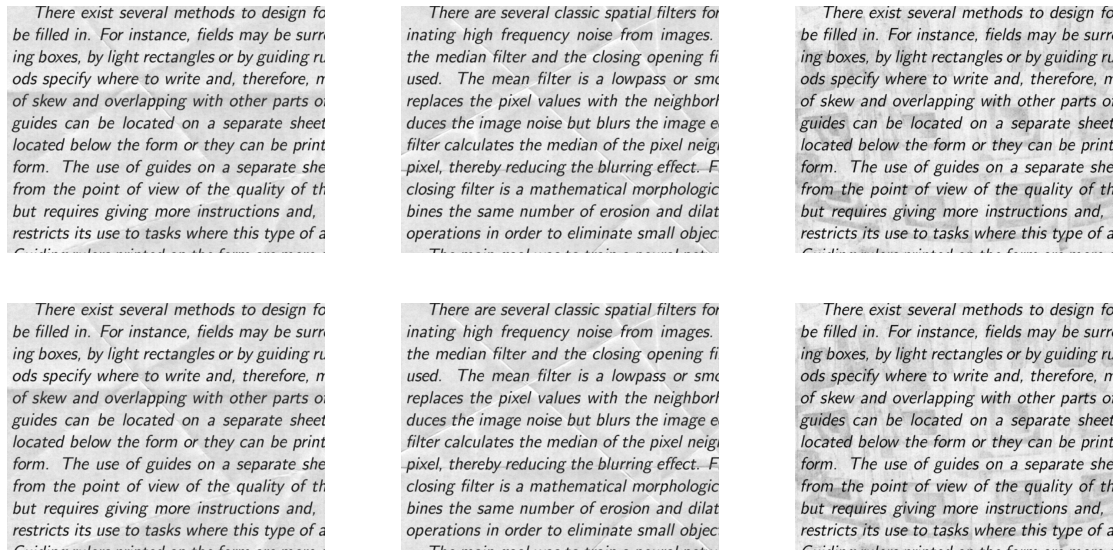

In [7]:
train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

samples = train_images[:3] + train_labels[:3]

f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img = plt.imread(train/img)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show()    

In [8]:
def get_cleaned_image(path):
    
    image_list = []
    
    img = img_to_array(load_img(train/train_images[i], color_mode='grayscale', target_size=(258,540))).astype('float32')/255.
    image_list.append(img)
    img = img*255.
    img = img[:,:,0] - cv2.medianBlur(img.astype('uint8'),9).astype('float32')
    img = ((img - img.min()) / (img.max()-img.min()))
    image_list.append(np.expand_dims(img,-1))
    ret,img = cv2.threshold(img,127/255,1,cv2.THRESH_BINARY)
    image_list.append(np.expand_dims(img,-1))
    pixvals = (img * 255.).astype('uint8') 
    ad_th = cv2.adaptiveThreshold(pixvals,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,15).astype('float32')/255.
    image_list.append(np.expand_dims(ad_th,-1))
    
    return np.array(image_list)

In [9]:
X=[]
y=[]

for path in train_images:
    x= get_cleaned_image(train/path)[-1]
    X.append(x)

for path in train_labels:
    x= img_to_array(load_img(train_cleaned/path, color_mode='grayscale', target_size=(258,540))).astype('float32')/255.
    y.append(x)

X = np.array(X)
y= np.array(y)

print(X.shape,y.shape)

(144, 258, 540, 1) (144, 258, 540, 1)


## Train, validation split

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(115, 258, 540, 1) (29, 258, 540, 1) (115, 258, 540, 1) (29, 258, 540, 1)


## Current MSE in train and validation

In [41]:
print("MSE in train is : "+ str(np.mean((X_train[:,:,:,0] - y_train[:,:,:,0]) ** 2)))
print("MSE in validation is : "+ str(np.mean((X_val[:,:,:,0] - y_val[:,:,:,0]) ** 2)))

## Define Model

In [54]:
model = Sequential()

model.add(Conv2D(64, kernel_size=3, padding='same', input_shape=(258,540,1), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(16, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(32,kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))

model.add(Conv2D(1,kernel_size=3, activation = 'sigmoid', padding='same'))

model.compile(optimizer= 'adam', loss='mean_squared_error')
callback = tf.keras.callbacks.EarlyStopping(patience = 10,verbose = 1, restore_best_weights = True)

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 258, 540, 64)      640       
_________________________________________________________________
batch_normalization_8 (Batch (None, 258, 540, 64)      256       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 258, 540, 32)      18464     
_________________________________________________________________
batch_normalization_9 (Batch (None, 258, 540, 32)      128       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 258, 540, 16)      4624      
_________________________________________________________________
batch_normalization_10 (Batc (None, 258, 540, 16)      64        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 258, 540, 32)     

## Training an evaluation on validation set

In [55]:
history = model.fit(X_train, y_train, validation_data= (X_val,y_val), 
                    epochs = 50, batch_size=20, verbose=1, callbacks = [callback])

Epoch 1/50
6/6 [==============================] - 262s 44s/step - loss: 0.1295 - val_loss: 0.1902
Epoch 2/50
6/6 [==============================] - 266s 44s/step - loss: 0.0757 - val_loss: 0.1554
Epoch 3/50
6/6 [==============================] - 261s 43s/step - loss: 0.0754 - val_loss: 0.1571
Epoch 4/50
6/6 [==============================] - 272s 45s/step - loss: 0.0743 - val_loss: 0.1360
Epoch 5/50
6/6 [==============================] - 268s 45s/step - loss: 0.0732 - val_loss: 0.1335
Epoch 6/50
6/6 [==============================] - 262s 44s/step - loss: 0.0720 - val_loss: 0.1195
Epoch 7/50
6/6 [==============================] - 263s 44s/step - loss: 0.0713 - val_loss: 0.1183
Epoch 8/50
6/6 [==============================] - 266s 44s/step - loss: 0.0705 - val_loss: 0.1103
Epoch 9/50
6/6 [==============================] - 288s 48s/step - loss: 0.0701 - val_loss: 0.1080
Epoch 10/50
6/6 [==============================] - 283s 47s/step - loss: 0.0704 - val_loss: 0.0969
Epoch 11/50
6/6 [==

In [56]:
model.save("filtered_deepcnn_model.h5")

In [57]:
def plot_history(history):

    plt.plot(history.epoch , history.history['loss'], label = 'train loss')
    plt.plot(history.epoch , history.history['val_loss'], color = 'red', linestyle = '--', label = 'val loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

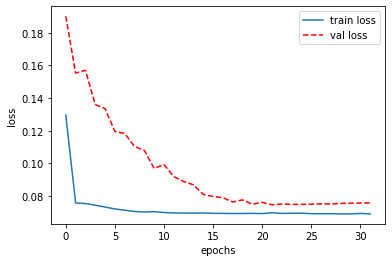

In [58]:
plot_history(history)